# Object Character Detection using YOLO8 and Tesseraact


## Project Overview
This project focuses on building an end-to-end system for automatic vehicle number plate detection and recognition using YOLOv8n and Tesseract OCR. YOLOv8, developed by Ultralytics, is a state-of-the-art computer vision model capable of performing tasks such as object detection, image segmentation, classification, and pose estimation. In this project, YOLOv8n is fine-tuned specifically to detect number plates from vehicle images.

The dataset used for training and evaluation is the [car-plate-detection](#https://www.kaggle.com/datasets/andrewmvd/car-plate-detection) dataset from Kaggle. The workflow begins by downloading the dataset, converting its annotations into YOLO-compatible format, and splitting the images into training and testing subsets. The YOLOv8 nano model is then trained, fine-tuned, and evaluated to measure detection performance.

After detection, each identified number plate region is passed to Tesseract, an open-source OCR engine widely used for text extraction from images. Tesseract integrates effectively with YOLO-based pipelines and enables us to convert detected number plates into readable alphanumeric text.

This project demonstrates a practical and scalable approach to vehicle number recognition. Such systems can be integrated into real-world applications including automated toll collection, traffic surveillance, vehicle verification, parking management, and insurance claim processing.


## Dependencies and Libraries

1. python version - python 3.11.4
2. Ultralytics YOLO
3. pytorch
4. CV2
5. Tesseract
6. Other libraries - os, matplotlib, xml.etree.ElementTree, numpy and pandas

In [20]:
#!pip install kaggle ultralytics ipywidgets numpy pandas os json matplotlib torch opencv-python
!pip install opencv-python ultralytics

  Using cached ultralytics-8.3.234-py3-none-any.whl.metadata (37 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 39.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 783.6/783.6 kB 68.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 MB 109.0 MB/s eta 0:00:00


## Download the Dataset

### Download Prerequisites.
- Login to kaggle and creat the KAGGLE_API_TOKEN.
- Configure the KAGGLE secrets - KAGGLE USERNAME and KAGGLE_API_TOKEN in coblab notebook secrets.
- Dataset URL : https://www.kaggle.com/datasets/andrewmvd/car-plate-detection

In [3]:
### Download the dataset from kaggle

import os
import json
from google.colab import userdata

# Define dataset and destination
dataset_name = 'andrewmvd/car-plate-detection'
destination_path = 'input'

# Create the destination directory if it doesn't exist
if not os.path.exists(destination_path):
    os.makedirs(destination_path)

# Get Kaggle API credentials from Colab secrets
kaggle_username = userdata.get('KAGGLE_USERNAME')
kaggle_key = userdata.get('KAGGLE_API_TOKEN') # Note: original secret name was KAGGLE_API_TOKEN

# Set environment variables (for explicit clarity, though kaggle.json is primary for CLI)
os.environ['KAGGLE_USERNAME'] = kaggle_username
os.environ['KAGGLE_KEY'] = kaggle_key

# Create the .kaggle directory in the user's home directory if it doesn't exist
kaggle_dir = os.path.expanduser('~/.kaggle')
if not os.path.exists(kaggle_dir):
    os.makedirs(kaggle_dir)

# Create kaggle.json file with the fetched credentials
kaggle_dict = {
    "username": kaggle_username,
    "key": kaggle_key
}
kaggle_json_path = os.path.join(kaggle_dir, 'kaggle.json')
with open(kaggle_json_path, "w") as f:
    json.dump(kaggle_dict, f)

# Set permissions for kaggle.json to be readable only by the owner
os.chmod(kaggle_json_path, 0o600)

# Download the dataset using Kaggle CLI
# The -p flag specifies the path to download the files to, and --unzip extracts them
!kaggle datasets download -d {dataset_name} -p {destination_path} --unzip

print(f"Dataset '{dataset_name}' downloaded and unzipped to '{destination_path}'.")

Dataset URL: https://www.kaggle.com/datasets/andrewmvd/car-plate-detection
License(s): CC0-1.0
  0% 0.00/203M [00:00<?, ?B/s]
100% 203M/203M [00:00<00:00, 3.24GB/s]
Dataset 'andrewmvd/car-plate-detection' downloaded and unzipped to 'input'.


## Import required libraries

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import re
import os
from glob import glob
import cv2
import xml.etree.ElementTree as xet


### Read Annotations from XML files

In [7]:
dataset_path = 'input'
labels_dict = dict(img_path=[], xmin=[], ymin=[], xmax=[], ymax=[], img_w=[], img_h=[])
xmls = glob(f'{dataset_path}/annotations/*.xml')
xmls[0:5]

['input/annotations/Cars233.xml',
 'input/annotations/Cars403.xml',
 'input/annotations/Cars404.xml',
 'input/annotations/Cars407.xml',
 'input/annotations/Cars133.xml']

In [8]:
def get_filename_number(filename):
    match = re.search(r'(\d+)', filename)
    if match:
        return int(match.group(0))
    else:
        return 0

for xml_file in sorted(xmls, key=get_filename_number):
    root = xet.parse(xml_file).getroot()
    ## Find Bounding boxes
    member_object = root.find('object')
    bndbox = member_object.find('bndbox')
    xmin = int(bndbox.find('xmin').text)
    ymin = int(bndbox.find('ymin').text)
    xmax = int(bndbox.find('xmax').text)
    ymax = int(bndbox.find('ymax').text)
    ## Find Image size
    size = root.find('size')
    img_w = int(size.find('width').text)
    img_h = int(size.find('height').text)
    ## Find Image path
    img_name = root.find('filename').text
    img_path = os.path.join(dataset_path, 'images', img_name)
    ## Append to dict
    labels_dict['img_path'].append(img_path)
    labels_dict['xmin'].append(xmin)
    labels_dict['ymin'].append(ymin)
    labels_dict['xmax'].append(xmax)
    labels_dict['ymax'].append(ymax)
    labels_dict['img_w'].append(img_w)
    labels_dict['img_h'].append(img_h)

xml_labels_df = pd.DataFrame(labels_dict)
xml_labels_df.head()

,img_path,xmin,ymin,xmax,ymax,img_w,img_h
0,input/images/Cars0.png,226,125,419,173,500,268
1,input/images/Cars1.png,134,128,262,160,400,248
2,input/images/Cars2.png,229,176,270,193,400,400
3,input/images/Cars3.png,142,128,261,157,400,225
4,input/images/Cars4.png,156,82,503,253,590,350


In [11]:
xml_labels_df.shape

(433, 7)

## Dataset - Convert the annotations to YOLO format

In [12]:
yolo_lables_dir = os.path.join('input', 'yolo_labels')
if not os.path.exists(yolo_lables_dir):
    os.makedirs(yolo_lables_dir)

def convert_to_yolo_format(row):
    img_w = row['img_w']
    img_h = row['img_h']
    xmin = row['xmin']
    ymin = row['ymin']
    xmax = row['xmax']
    ymax = row['ymax']
    # Calculate YOLO format values
    x_center = ((xmin + xmax) / 2.0) / img_w
    y_center = ((ymin + ymax) / 2.0) / img_h
    width = (xmax - xmin) / img_w
    height = (ymax - ymin) / img_h
    # Assuming class_id is 0 for text
    return f"0 {x_center} {y_center} {width} {height}"

for img, row in xml_labels_df.groupby('img_path'):
    yolo_label = convert_to_yolo_format(row.iloc[0])
    label_filename = os.path.splitext(os.path.basename(img))[0] + '.txt'
    label_path = os.path.join(yolo_lables_dir, label_filename)
    with open(label_path, 'w') as f:
        f.write(yolo_label)

In [33]:
### Split Training, Test and Validation datasets
from sklearn.model_selection import train_test_split

yolo_lables_dir = os.path.join('input', 'yolo_labels') # This directory holds initial YOLO labels before splitting

data_dir = "dataset"
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

train_img_dir = os.path.join(data_dir, 'train', 'images')
train_label_dir = os.path.join(data_dir, 'train', 'labels')
val_img_dir = os.path.join(data_dir, 'val', 'images')
val_label_dir = os.path.join(data_dir, 'val', 'labels')
test_img_dir = os.path.join(data_dir, 'test','images')
test_label_dir = os.path.join(data_dir, 'test','labels')

# Create all necessary image and nested labels directories
for dir_path in [train_img_dir, val_img_dir, test_img_dir,
                 train_label_dir, val_label_dir, test_label_dir]:
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)

In [34]:
# Create the training, test and validation dataframes
train_df, test_df = train_test_split(xml_labels_df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)
print(f"Train shape: {train_df.shape}")
print(f"Validation shape: {val_df.shape}")
print(f"Test shape: {test_df.shape}")

Train shape: (311, 7)
Validation shape: (35, 7)
Test shape: (87, 7)


In [35]:
### Copy images and labels to respective directories
def copy_data_to_yolo_format(df, img_dest_dir, label_dest_dir):
    #label_dest_dir = os.path.join(img_dest_dir, 'labels') # Labels go into a 'labels' subdirectory of the image directory

    # Ensure the label destination directory exists (though already created in previous cell)
    if not os.path.exists(label_dest_dir):
        os.makedirs(label_dest_dir)

    for _, row in df.iterrows():
        img_src_path = row['img_path']
        label_filename = os.path.splitext(os.path.basename(img_src_path))[0] + '.txt'
        label_src_path = os.path.join(yolo_lables_dir, label_filename) # Source is still from the initial yolo_labels dir

        # Copy image
        img_dest_path = os.path.join(img_dest_dir, os.path.basename(img_src_path))
        # Ensure image is read correctly (cv2.imread returns None if file not found/corrupt)
        img = cv2.imread(img_src_path)
        if img is not None:
            cv2.imwrite(img_dest_path, img)
        else:
            print(f"Warning: Could not read image {img_src_path}")


        # Copy label
        label_dest_path = os.path.join(label_dest_dir, label_filename)
        if os.path.exists(label_src_path):
            with open(label_src_path, 'r') as f_src:
                label_data = f_src.read()
            with open(label_dest_path, 'w') as f_dest:
                f_dest.write(label_data)
        else:
            print(f"Warning: Label file not found for {img_src_path} at {label_src_path}")


# Call the updated copy function
copy_data_to_yolo_format(train_df, train_img_dir, train_label_dir)
copy_data_to_yolo_format(val_df, val_img_dir, val_label_dir)
copy_data_to_yolo_format(test_df, test_img_dir, test_label_dir) # Use test_img_dir as the base for test labels

print(f"Data copied to {data_dir} directory in YOLO format.")

Data copied to dataset directory in YOLO format.


In [36]:
train_df.head()

,img_path,xmin,ymin,xmax,ymax,img_w,img_h
10,input/images/Cars10.png,140,5,303,148,400,225
270,input/images/Cars270.png,75,173,125,195,400,225
85,input/images/Cars85.png,86,218,146,235,400,267
271,input/images/Cars271.png,262,141,318,160,400,266
178,input/images/Cars178.png,126,180,173,205,300,223


### Object detection using YOLO

### Show sample image with bounding box

In [37]:
sample_image_path = train_df.iloc[2]['img_path']
sample_label_file = os.path.splitext(os.path.basename(sample_image_path))[0] + '.txt'
print(f'sample_image selected: {sample_image_path}, sample_label_file: {sample_label_file}')

sample_image selected: input/images/Cars85.png, sample_label_file: Cars85.txt


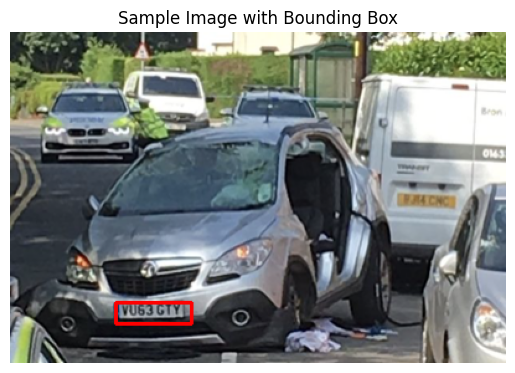

In [39]:
sample_image = cv2.imread(sample_image_path)
sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)
sample_label_path = os.path.join('dataset', 'train','labels', sample_label_file)
# Construct the correct path to the label file within the new YOLO structure
# Assuming the sample image is from the training set based on `train_df.iloc[0]`
sample_img_dir_base = os.path.join('dataset', 'train_images')


if not os.path.exists(sample_label_path):
    print(f"Error: Label file not found at {sample_label_path}. Please ensure data copying is correct.")
else:
    with open(sample_label_path, 'r') as f:
        yolo_data = f.read()
        # Make sure yolo_data is not empty before processing
        if yolo_data.strip():
            for line in yolo_data.splitlines():
                class_id, x_center, y_center, width, height = map(float, line.split())
                # Denormalize coordinates
                x_center *= sample_image.shape[1]
                y_center *= sample_image.shape[0]
                box_width = width * sample_image.shape[1]
                box_height = height * sample_image.shape[0]
                box = [
                    int(x_center - box_width / 2),
                    int(y_center - box_height / 2),
                    int(x_center + box_width / 2),
                    int(y_center + box_height / 2)
                ]
                cv2.rectangle(sample_image, (box[0], box[1]), (box[2], box[3]), (255, 0, 0), 2)
            plt.imshow(sample_image)
            plt.axis('off')
            plt.title("Sample Image with Bounding Box")
            plt.show()
        else:
            print(f"Warning: Label file {sample_label_path} is empty.")

## Training YOLO8 Model for car number plate detection

In [40]:
## dataset.yaml file for YOLOv8 training
dataset_yaml_content = """
path: ./dataset
train: train/images
test: test/images
val: val/images

names:
  0: car_number
"""
with open('dataset.yaml', 'w') as f:
    f.write(dataset_yaml_content)
print("Dataset YAML file created at dataset.yaml")

Dataset YAML file created at dataset.yaml


In [42]:
from ultralytics import YOLO
model = YOLO('yolov8n.pt')  # load a pretrained YOLOv8n model
model.train(data='dataset.yaml', epochs=50, imgsz=640, batch=8, name='car_number_ocr')


Ultralytics 8.3.234 🚀 Python-3.12.12 torch-2.9.0+cpu CPU (AMD EPYC 9B14)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=car_number_ocr5, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=Tr

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7b31f2450890>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

## Save the Model

In [75]:
model.save('car_number_plat_reader.pt')
loaded_model = YOLO('car_number_plat_reader.pt')

## Test the trained Model


In [84]:
def predict_car_number(model, image_path):
    results = model.predict(image_path, device='cpu')
    p_image = cv2.imread(image_path)
    p_image = cv2.cvtColor(p_image, cv2.COLOR_BGR2RGB)
    for result in results:
        boxes = result.boxes
        for box in boxes:
            b = box.xyxy[0].tolist()
            class_id = int(box.cls[0])
            confidence = float(box.conf[0]) # Get confidence score
            label = model.names[class_id] if hasattr(model, 'names') else str(class_id)
            display_text = f"{label}: {confidence:.2f}" # Combine label and confidence
            cv2.rectangle(p_image, (int(b[0]), int(b[1])), (int(b[2]), int(b[3])), (0, 255, 0), 2)
            cv2.putText(p_image, display_text, (int(b[0]), int(b[1]) - 10 if int(b[1]) - 10 > 10 else int(b[1]) + 20), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
    plt.imshow(p_image)
    plt.axis('off')
    plt.title("Sample Image with Bounding Box and Confidence")
    plt.show()

### Predict - 1

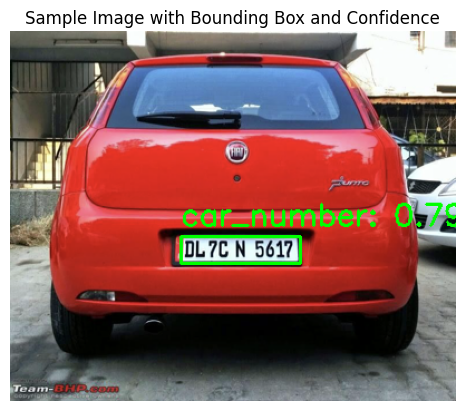

In [101]:
predict_image_path = test_df.iloc[20]['img_path']
predict_car_number(loaded_model, predict_image_path)

### Predict -2

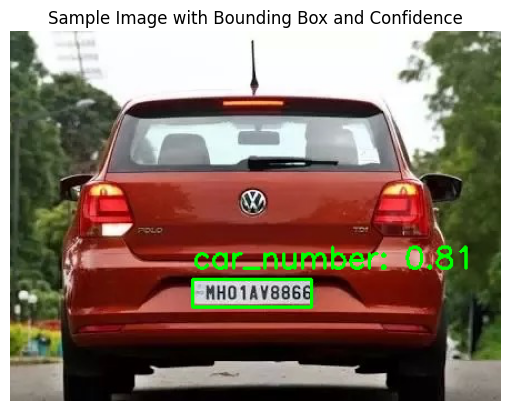

In [102]:
predict_image_path = test_df.iloc[25]['img_path']
predict_car_number(loaded_model, predict_image_path)

# Extract car number into text using pytesseract

In [93]:
!pip install pytesseract

In [99]:
import pytesseract
from pytesseract import Output

def extract_text_from_image(model, image_path):
    # Perform detection with YOLO model
    results = model.predict(image_path, device='cpu', verbose=False)
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    extracted_texts = []

    for result in results:
        boxes = result.boxes
        for box in boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cropped_plate = img[y1:y2, x1:x2]
            text = pytesseract.image_to_string(cropped_plate, config='--psm 8')
            extracted_texts.append(text.strip())
    plt.imshow(img)
    plt.axis('off')
    plt.title("Sample Image with Bounding Box and Text")
    plt.show()
    print(extracted_texts)

## Text extract - 1

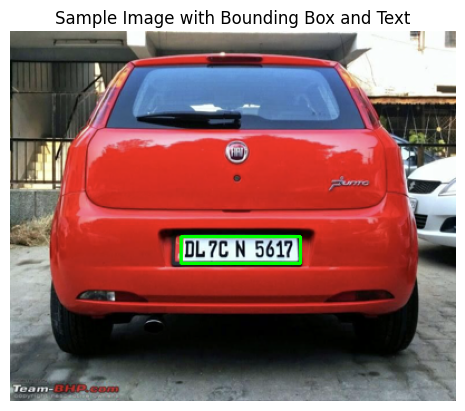

['DL7C N 5617!']


In [103]:
predict_image_path = test_df.iloc[20]['img_path']
extract_text_from_image(loaded_model, predict_image_path)

## Text Extract - 2

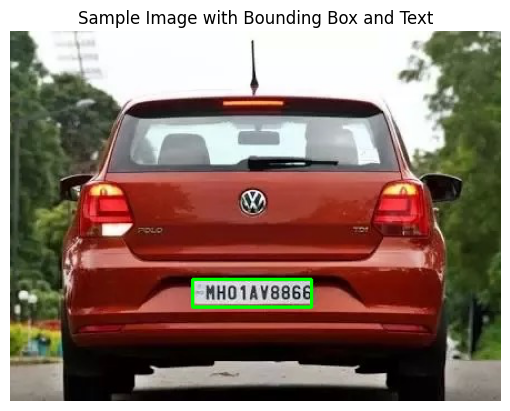

['-MHO1AV8866']


In [104]:
predict_image_path = test_df.iloc[25]['img_path']
extract_text_from_image(loaded_model, predict_image_path)